# Dependencies

In [ ]:
%reset  -f
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_probability as tfp
from tensorflow.keras import layers
import scipy.stats as si
from scipy.stats import norm
tf.keras.backend.set_floatx('float32')
from google.colab import drive
import os
import datetime
import csv
import time
import os
import random
import pickle
from datetime import datetime
from matplotlib.lines import Line2D

# Parameter Initilization

In [ ]:

# NN params
num_epochs = 10
batch_size = 2**11 #2**12
initial_lr = 0.005
neurons = [100,100,100]
M_train = 2**18  # Number training of samples

# Parameters
M = 2**12  # Number eval of samples
N = 40  # Number of time steps
d = 1  # Number of dimensions
P_Y = 1 # dimensions of Y
P_Z = d # dimensions of Z
early_stop = False
if early_stop:
  num_epochs = 100

T = 1.0  # Total time
t = np.linspace(0, T, N+1, dtype=np.float32)
h = t[1] - t[0]
x0 = np.ones([M_train,d])
mu = 0.05 # for problem 1B
#mu = -0.05 # For problem 2
#mu = 0.25 # For problem 1

sigma_diag = tf.constant([0.3, 0.375, 0.45, 0.375, 0.3, 0.375, 0.45, 0.375, 0.3, 0.375, 0.45, 0.375, 0.3, 0.375, 0.45, 0.375, 0.3, 0.375, 0.45, 0.375]) #Problem 2
sigma_diag = tf.linspace(0.3,0.45, d)
#sigma_diag =  tf.constant([.2, .25, .3, .35, .45]) # Problem 1B #
sigma_diag = tf.linspace(0.2,0.45, d)
#sigma_diag = tf.constant([.8, .9, 1., 1.1, 1.2])  # For problem 1A
#sigma_diag = 2*tf.constant([.2, .25, .3, .35, .45]) # Problem 3
sigma = tf.linalg.diag(sigma_diag)
v = tf.constant([1., 1., 1., 1., 1.])
#v = tf.constant([1.])
terminal = 't_sinX_T'
#terminal = 'tpX_tX_T'
SDE = 'ABM'
SDE = 'GBM'
#SDE = 'sin_drift'
#SDE = 'sin_cos_drift'
#SDE = 'fully_coupled'
coupled = False

model_parameters = [SDE, terminal, h, d, mu, sigma, v, coupled]

model = ModelClass(model_parameters)

x = np.zeros([M,d,N+1])
x[:,:,0] = x0[:M,:]
x_EM = np.zeros([M,d,N+1])
x_EM[:,:,0] = x0[:M,:]

for i in range(N):
  dW = np.random.normal(size=(M, d)) * np.sqrt(h)
  x[:,:,i+1] = model.F_X(x[:,:,i], dW, t[i+1])
  if not coupled:
    x_EM[:,:,i+1] = model.F_X_EM(x_EM[:,:,i], dW)


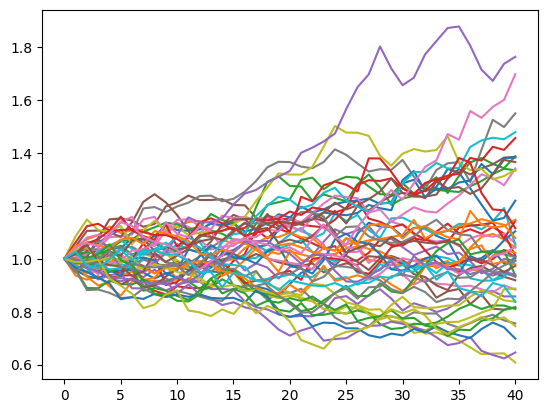

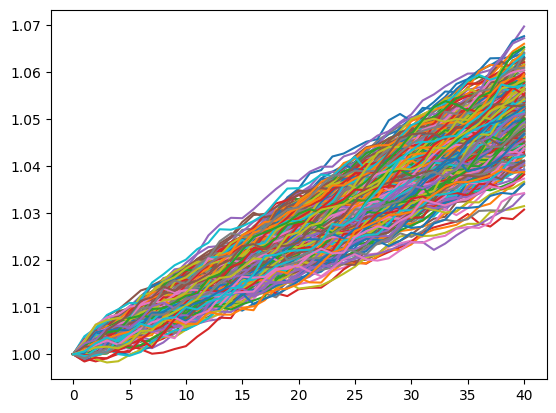

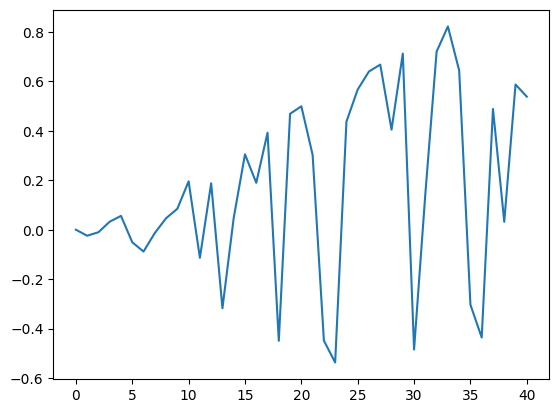

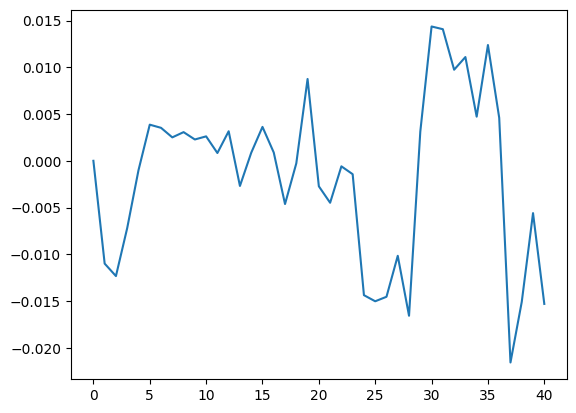

In [ ]:
plt.plot(x[:50,0,:].T)
plt.figure()
plt.plot(np.mean(x[:,:,:],0).T)
plt.figure()
plt.plot(t * np.sin(np.sum(x[0,:,:],0)))
plt.figure()
plt.plot(t * np.mean(np.sin(np.sum(x,1)),0))


# Model class - Defining the mathematical problem

In [ ]:
# @title
################ this code is for the general LQ problems with any possible dimensions (dim_x, dim_u, dim_w)
class ModelClass:
  def __init__(self, model_parameters):

    self.SDE = model_parameters[0]
    self.terminal = model_parameters[1]
    self.h = model_parameters[2]
    self.d = model_parameters[3]

    self.mu = model_parameters[4]
    self.sigma = model_parameters[5]
    self.v = model_parameters[6]
    self.coupled = model_parameters[7]
    if self.coupled:
      self.mu = tf.cast(self.mu, tf.float32)
      self.h = tf.cast(self.h, tf.float32)
      self.sigma = tf.cast(self.sigma, tf.float32)
    self.alpha2 = tf.linalg.trace(tf.transpose(self.sigma) @ self.sigma)
    self.sigma_inv = tf.linalg.inv(self.sigma)
    self.sig_sigT_diag = tf.linalg.diag_part(self.sigma @ tf.transpose(self.sigma))
    self.IT_sigma = tf.reduce_sum(sigma, axis=0)
    self.norm_sq = tf.reduce_sum(tf.square(tf.reduce_sum(sigma, axis=0)))  # scalar
    self.a = tf.reshape(tf.linspace(-0.15, 0.15, self.d), [1, self.d])

  def F_X(self, x, dW, t=None):
    if self.SDE == 'ABM':
      x = x + self.mu * self.h + dW @ self.sigma

    elif self.SDE == 'GBM':
      drift = self.mu - 0.5 * self.sig_sigT_diag
      random_part = dW @ self.sigma
      exponent = drift * self.h + random_part
      x = x * tf.exp(exponent)
    elif self.SDE == 'sin_drift':
      x = tf.convert_to_tensor(x, dtype=tf.float32)
      dW = tf.convert_to_tensor(dW, dtype=tf.float32)
      x = x + t * self.mu * tf.sin(x) * self.h + dW * self.sigma
    elif self.SDE == 'sin_cos_drift':
      x = tf.convert_to_tensor(x, dtype=tf.float32)
      dW = tf.convert_to_tensor(dW, dtype=tf.float32)
      x = x + (t * self.mu * tf.sin(x) + t * tf.cos(x)) * self.h + dW * self.sigma
    elif self.SDE == 'fully_coupled':
      x = tf.convert_to_tensor(x, dtype=tf.float32)
      sum_x = tf.reduce_sum(x, axis = 1, keepdims=True)
      dW = tf.convert_to_tensor(dW, dtype=tf.float32)
      x = x + ( self.a * (1 - t) + self.mu * self.IT_sigma * t * tf.cos(sum_x) * (1 + t*tf.sin(sum_x)) ) * self.h + (1 + t * tf.sin(sum_x)) * dW @ self.sigma


    return x


  def F_X_EM(self, x, dW, y=None, z=None, t= None):
    if self.SDE == 'ABM':
      x = x + self.mu * self.h + dW @ self.sigma
      #x = x + self.mu * self.h + dW
    elif self.SDE == 'GBM':
      x = x + self.mu * x * self.h + x @ self.sigma * dW
    elif self.SDE == 'sin_drift':
      x = x + self.mu * y * self.h + dW @ self.sigma
    elif self.SDE == 'sin_cos_drift':
      x = x + (self.mu * y + 1/self.sigma * z) * self.h + dW @ self.sigma
    elif self.SDE == 'fully_coupled':
      x = x + (self.a*(1 - t) + self.mu * z) * self.h + (y + 1) * dW @ self.sigma
    return x



  def F_Y(self, t, s, xt, x, y, z, dW):
    if self.terminal == 't_sinX_T':
      sum_x = (5/self.d)*tf.reduce_sum(x, axis = 1, keepdims=True)
      if self.SDE == 'ABM':
        #Delta_y = -( t/2 * self.alpha2 * tf.sin(sum_x) - self.d * self.mu / self.alpha2 * tf.reduce_sum(z @ self.sigma, axis=1, keepdims=True)) * self.h + tf.reduce_sum(z * dW, axis = 1, keepdims = True)
        Delta_y = -( t/2 * self.alpha2 * tf.sin(sum_x)  - self.mu * tf.reduce_sum(z, axis=1, keepdims=True)) * self.h + tf.reduce_sum((z @ self.sigma) * dW, axis = 1, keepdims = True)
        #Delta_y = -( t/2 * self.d * tf.sin(sum_x) - self.mu * tf.reduce_sum(z, axis=1, keepdims=True)) * self.h + tf.reduce_sum(z * dW, axis = 1, keepdims = True)
        # + tf.sin(s * tf.sin(sum_x)) - tf.sin(y)
      elif self.SDE == 'GBM':
        Delta_y = -( t/2 * tf.sin(sum_x) * tf.reduce_sum(( (5/self.d)*x @ sigma )**2, axis = 1, keepdims=True)  - self.mu * tf.reduce_sum(x * z, axis=1, keepdims=True)) * self.h + tf.reduce_sum((z * ( x  @ self.sigma) ) * dW, axis = 1, keepdims = True)
      elif self.SDE == 'sin_drift':
        Delta_y = -(t * 0.5 * self.sigma**2 * tf.sin(x) - self.mu * y * z)*h + z*dW
      elif self.SDE == 'sin_cos_drift':
        Delta_y = -(t * 0.5 * self.sigma**2 * tf.sin(x) + t - self.mu * y * z - 1/self.sigma * s * tf.cos(x) * z) * h + z * dW
      elif self.SDE == 'fully_coupled':
        Delta_y = -(t * 0.5 * tf.sin(sum_x) * (y + 1)**2 * self.norm_sq - tf.cos(sum_x) * (t * tf.reduce_sum(self.a * (1-s), axis=1, keepdims=True) + s * self.mu * tf.reduce_sum(z, axis=1, keepdims=True))) * h + tf.reduce_sum(z * dW, axis = 1, keepdims = True)

    elif self.terminal == 'tpX_tX_T':
      #Delta_y = self.mu * tf.reduce_sum(z @ self.sigma_inv, axis = 1, keepdims = True) * self.h + tf.reduce_sum(z * dW, axis = 1, keepdims = True)
      Delta_y = self.mu * tf.reduce_sum(z * x, axis = 1, keepdims = True) * self.h + tf.reduce_sum((z * ( x  @ self.sigma) ) * dW, axis = 1, keepdims = True)

    return Delta_y


  def g(self, t, xt, x):
    if self.terminal == 't_sinX_T':
      sum_x = (5/self.d)*tf.reduce_sum(x, axis = 1, keepdims=True)
      g = t * tf.sin(sum_x)

      # Cast the final output to float32
      g = tf.cast(g, tf.float32)
    elif self.terminal == 'tpX_tX_T':
      g = tf.reduce_sum((t + xt) * x, axis = 1, keepdims = True)
      g = tf.cast(g, tf.float32)

    return g









# Neural Network Class

In [ ]:
############## Define Neural Network Classes ##############
class SubNetwork(tf.keras.Model):   # 3 call methods, "call" for Vx, "second_call" for Vxx, "y0_call" for y0 used in deep DP
    def __init__(self, dim_x, dim_w, portfolio_pars, neurons, activation, use_batnorm = False, regu_cons=[0., 0.], ini_cons=None ):
        super(SubNetwork, self).__init__()
        self.d = dim_x
        self.m = dim_w
        self.neurons = neurons
        self.activation = activation
        self.P_Y = portfolio_pars[0]
        self.P_Z = portfolio_pars[1]
        self.use_batnorm = use_batnorm
        self.regu_1 = tf.keras.regularizers.L2( l2=regu_cons[0] )   # should same as self.regu_1 = None
        self.regu_2 = tf.keras.regularizers.L2( l2=regu_cons[1] )
        if ini_cons == None:
          self.ini_1 = "glorot_uniform"
          self.ini_2 = "zeros"
        else:
          self.ini_1 = tf.keras.initializers.Constant(value=ini_cons[0])
          self.ini_2 = tf.keras.initializers.Constant(value=ini_cons[1])
        self.dense_layers1 = []       # 12 are for each call method below
        self.dense_layers2 = []
        self.batch_norm1 = []
        self.batch_norm2 = []
        for i in range(len(self.neurons)):
            self.dense_layers1.append( tf.keras.layers.Dense(self.neurons[i], activation=self.activation, use_bias=True, \
                    kernel_regularizer=self.regu_1, bias_regularizer=self.regu_2, kernel_initializer=self.ini_1, bias_initializer=self.ini_2) )
            self.dense_layers2.append( tf.keras.layers.Dense(self.neurons[i], activation=self.activation, use_bias=True, \
                    kernel_regularizer=self.regu_1, bias_regularizer=self.regu_2, kernel_initializer=self.ini_1, bias_initializer=self.ini_2) )
            self.batch_norm1.append( tf.keras.layers.BatchNormalization() )
            self.batch_norm2.append( tf.keras.layers.BatchNormalization() )
        self.dense_out1 = tf.keras.layers.Dense(self.P_Z, activation='linear', use_bias=True, \
                            kernel_regularizer=self.regu_1, bias_regularizer=self.regu_2, kernel_initializer=self.ini_1, bias_initializer=self.ini_2)
        self.dense_out2 = tf.keras.layers.Dense(self.P_Y, activation='linear', use_bias=True, \
                            kernel_regularizer=self.regu_1, bias_regularizer=self.regu_2, kernel_initializer=self.ini_1, bias_initializer=self.ini_2)
    def call(self, x_in):         # get z.
        x = x_in
        #x = tf.squeeze(x_in, axis=-1)     # x_in.shape =[B,d]
        for i in range(len(self.neurons)):
            x = self.dense_layers1[i](x)
            if self.use_batnorm:
              x = self.batch_norm1[i](x)
        x = self.dense_out1(x)
        return x    # output shape = [B,P_Z]
    def y_call(self, x_in):     # get Y_0 = V(0, x_0)
        x = x_in
        #x = tf.squeeze(x_in, axis=-1)
        for i in range(len(self.neurons)):
            x = self.dense_layers2[i](x)
            if self.use_batnorm:
              x = self.batch_norm2[i](x)
        x = self.dense_out2(x)
        return x     # output shape = [B,P_Y]

class FullNetwork(tf.keras.Model):
    def __init__(self, N, h, dim_x, dim_w, portfolio_pars, neurons=[16,16,16], activation='relu', use_batnorm=False, regu_cons=[0.,0.], ini_cons=None):
        super(FullNetwork, self).__init__()
        self.N = N    # number of subNN
        self.h = h    # step size
        self.dim_x = dim_x
        self.dim_w = dim_w
        self.portfolio_parameters = portfolio_pars
        self.P_Y = portfolio_pars[0]
        self.P_Z = portfolio_pars[1]
        self.neurons = neurons
        self.activation = activation
        self.use_batnorm = use_batnorm
        self.regu_cons = regu_cons
        self.ini_cons = ini_cons
        self.network_z = SubNetwork(dim_x=self.dim_x, dim_w=self.dim_w, portfolio_pars = self.portfolio_parameters, neurons=self.neurons, activation=self.activation, \
                                           use_batnorm=self.use_batnorm, regu_cons=self.regu_cons, ini_cons=self.ini_cons)
        #self.y_0 = self.add_weight(name="y_0", shape=[self.P_Y], initializer=tf.keras.initializers.RandomUniform(minval=0.0, maxval=0.1), trainable=True)

        self.network_y = SubNetwork(dim_x=self.dim_x, dim_w=self.dim_w, portfolio_pars = self.portfolio_parameters, neurons=self.neurons, activation=self.activation, \
                                           use_batnorm=self.use_batnorm, regu_cons=self.regu_cons, ini_cons=self.ini_cons)

    def call(self, x_input):    # input shape x=[B,d,1]
        ########## deep DP
        NNx = tf.TensorArray(dtype=tf.float32, size=self.N + 1, dynamic_size=False, clear_after_read=False)
        NNy = tf.TensorArray(dtype=tf.float32, size=self.N + 1, dynamic_size=False, clear_after_read=False)
        NNz = [
            tf.TensorArray(
                dtype=tf.float32,
                size=n+1,  # For outer time step n, there are self.N - n - 1 inner elements
                dynamic_size=False,
                clear_after_read=False
            )
            for n in range(self.N)
        ]
        YN_target = tf.TensorArray(dtype=tf.float32, size=self.N, dynamic_size=False, clear_after_read=False)
        # Pre-fill each element with a zeros vector of shape [batch_size]
        for k in range(self.N):
          YN_target = YN_target.write(k, tf.zeros([batch_size, self.P_Y], dtype=tf.float32))
        gxN = tf.TensorArray(dtype=tf.float32, size=self.N, dynamic_size=False, clear_after_read=False)


        for n in range(0, self.N):
          dW = tf.random.normal( shape = [batch_size,self.P_Z], mean=0, stddev=np.sqrt(self.h))
          time_tensor = tf.fill([batch_size, 1], tf.cast(n * self.h, dtype=tf.float32))
          if n == 0:
            NNx = NNx.write(0, x_input)
            #NNy = NNy.write(0, tf.broadcast_to(self.y_0, [batch_size, self.P_Y]))  # Broadcasting y_0

          inp_y = tf.concat([NNx.read(n), time_tensor], axis=1)
          NNy = NNy.write(n, self.network_y.y_call( inp_y ))

          for k in range(0, n+1):
            time_tensor_Z = tf.concat([tf.fill([batch_size, 1], tf.cast(k * self.h, tf.float32)), tf.fill([batch_size, 1], tf.cast(n * self.h, tf.float32))], axis=1)
            if terminal == 't_sinX_T':
              inp_Z = tf.concat([NNx.read(n), time_tensor_Z], axis=1)
            elif terminal == 'tpX_tX_T':
              inp_Z = tf.concat([NNx.read(k), NNx.read(n), time_tensor_Z], axis=1)
            NNz[n] = NNz[n].write(k, self.network_z(inp_Z))

            YN_target_current_val = YN_target.read(k)
            Delta_YN_target = model.F_Y(k * self.h, n * self.h, NNx.read(k), NNx.read(n), NNy.read(n), NNz[n].read(k), dW)
            YN_target_new_val = YN_target_current_val + Delta_YN_target
            if k<n:
              YN_target = YN_target.write(k, YN_target_new_val)
            else:
              YN_target = YN_target.write(k, NNy.read(k))

          if coupled:
            NNx = NNx.write(n + 1, model.F_X_EM(NNx.read(n), dW, NNy.read(n), NNz[n].read(n), n*self.h))
          else:
            NNx = NNx.write(n + 1, model.F_X(NNx.read(n), dW))

        # Calculate the final loss as before
        loss_final = 0
        for k in range(0, self.N):
          gxN = gxN.write(k, model.g(k * self.h, NNx.read(k), NNx.read(self.N)))
          loss_final += tf.reduce_mean(( YN_target.read(k) - gxN.read(k) ) ** 2)

        # Return all the individual losses and the final loss
        return loss_final
    def simulate(self, x_input):

        # M: number of evaluation samples (dynamically determined)
        M = tf.shape(x_input)[0]

        # Create TensorArrays for X and Y with fully specified element shapes.
        NNx = tf.TensorArray(
            dtype=tf.float32,
            size=self.N + 1,
            element_shape=tf.TensorShape([None, self.dim_x]),
            dynamic_size=False,
            clear_after_read=False
        )
        NNy = tf.TensorArray(
            dtype=tf.float32,
            size=self.N + 1,
            element_shape=tf.TensorShape([None, self.P_Y]),
            dynamic_size=False,
            clear_after_read=False
        )
        # For Z, each time step n stores n+1 elements, each with shape [M, P_Z].
        NNz = [
            tf.TensorArray(
                dtype=tf.float32,
                size=n + 1,
                element_shape=tf.TensorShape([None, self.P_Z]),
                dynamic_size=False,
                clear_after_read=False
            )
            for n in range(self.N + 1)
        ]

        # Set initial conditions.
        NNx = NNx.write(0, x_input)  # X(0)
        NNy = NNy.write(0, tf.broadcast_to(self.y_0, [M, self.P_Y]))  # Y(0)

        # Loop over time steps. Use tf.range for graph compatibility.
        for n in tf.range(self.N):
            # Generate random increment dW for time step n.
            dW = tf.random.normal(
                shape=[M, self.dim_w],
                mean=0.0,
                stddev=tf.sqrt(tf.cast(self.h, tf.float32))
            )
            # Create a time tensor for current time t = n*h.
            current_time = tf.fill([M, 1], tf.cast(n * self.h, tf.float32))

            # For n>=1, update Y using the dedicated y_call method.
            # (At n == 0, Y(0) was already set.)
            if n > 0:
                inp_y = tf.concat([NNx.read(n), current_time], axis=1)
                y_n = self.network_y.y_call(inp_y)
                NNy = NNy.write(n, y_n)

            # For each valid k (0,...,n), compute Z(t_k,t_n).
            for k in tf.range(n + 1):
                time_tensor_Z = tf.concat([
                    tf.fill([M, 1], tf.cast(k * self.h, tf.float32)),
                    tf.fill([M, 1], tf.cast(n * self.h, tf.float32))
                ], axis=1)
                #inp_Z = tf.concat([NNx.read(n), time_tensor_Z], axis=1)
                inp_Z = tf.concat([NNx.read(k), NNx.read(n), time_tensor_Z], axis=1)
                z_val = self.network_z(inp_Z)
                NNz[n] = NNz[n].write(k, z_val)

            # Update X using your dynamics (here via the globally defined model.F_X_EM).
            x_next = model.F_X_EM(NNx.read(n), dW)
            NNx = NNx.write(n + 1, x_next)

        # Update Y at the final time step.
        final_time = tf.fill([M, 1], tf.cast(self.N * self.h, tf.float32))
        inp_y_final = tf.concat([NNx.read(self.N), final_time], axis=1)
        y_final = self.network_y.y_call(inp_y_final)
        NNy = NNy.write(self.N, y_final)

        # Stack the TensorArrays.
        # NNx.stack() has shape [N+1, M, d] so we transpose to [M, N+1, d].
        X_paths = tf.transpose(NNx.stack(), perm=[1, 0, 2])



# Initialize and Train the Neural Network


Start of epoch 0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'sub_network_30', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'full_network_15', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Training loss at step 0: 0.1629
Seen so far: 2048 samples
The current learning rate is 0.0049921935
Time elapsed 266.5218379497528

Start of epoch 1
Training loss at step 0: 0.0069
Seen so far: 2048 samples
The current learning rate is 0.0040872623
Time elapsed 44.017903089523315

Start of epoch 2
Training loss at step 0: 0.0052
Seen so far: 2048 samples
The current learning rate is 0.0033463677
Time elapsed 43.71411204338074

Start of epoch 3
Training loss at step 0: 0.0050
Seen so far: 2048 samples
The current learning rate is 0.0027397743
Time elapsed 44.00992798805237

Start of epoch 4
Training loss at step 0: 0.0048
Seen so far: 2048 samples
The current learning rate is 0.0022431372
Time elapsed 43.852948904037476

Start of epoch 5
Training loss at step 0: 0.0048
Seen so far: 2048 samples
The current learning rate is 0.0018365256
Time elapsed 43.667020320892334

Start of epoch 6
Training loss at step 0: 0.0047
Seen so far: 2048 samples
The current learning rate is 0.00150362
Time 

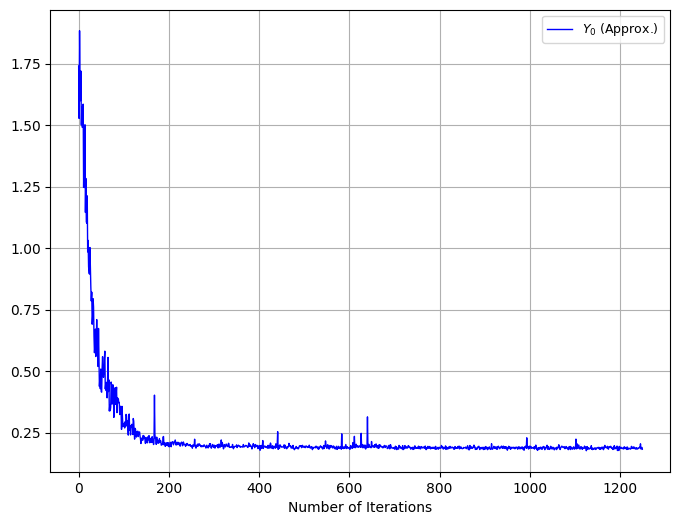

In [ ]:
# Convert parameters to tensors as before
model_parameters_tf = [SDE, terminal, h, d, mu, sigma, v, coupled]
x0_tf = tf.convert_to_tensor(x0, dtype=tf.float32)
# Make sure P_Y and P_Z are defined (for example, integers)
portfolio_parameters_tf = [P_Y, P_Z]

# Create the full model
full_model = FullNetwork(N=N, h=h, dim_x=d, dim_w=d,
                           portfolio_pars=portfolio_parameters_tf,
                           neurons=neurons, activation='relu',
                           use_batnorm=False, regu_cons=[0., 0.],
                           ini_cons=None)

# Prepare the training dataset
x_train = x0_tf  # shape = [M_train, dim_x] (adjust if needed to match your model input shape)
y_train = tf.zeros([M_train, 1, 1])
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(batch_size)

# Adjust dummy_loss to match the scalar output of full_model
def dummy_loss(y_true, y_model):
    # Since full_model returns a scalar loss, simply wrap it in a list.
    return [y_model]

# Set up the learning rate schedule and optimizer as before
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr,
    decay_steps=int(M_train/batch_size),
    decay_rate=tf.math.exp(-0.2),
    staircase=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Define the training step function
@tf.function
def train_step(input_x, input_y):
    with tf.GradientTape() as tape:
        fullmodel_output = full_model(input_x, training=True)
        loss_list = dummy_loss(input_y, fullmodel_output)
        # Extract the final loss (the only element in our case)
        loss_value = loss_list[-1]
    grads = tape.gradient(loss_value, full_model.trainable_weights)
    optimizer.apply_gradients(zip(grads, full_model.trainable_weights))
    return loss_list, loss_value, grads

# Customized training loop
if early_stop:
  # Early-stopping parameters
  patience = 3
  best_loss = float('inf')
  wait = 0

  # Customized training loop with early stopping
  loss_history = []
  lr_history = []
  start = time.time()
  for epoch in range(num_epochs):
      print(f"\nStart of epoch {epoch}")
      epoch_losses = []

      for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
          loss_list, loss_value, grads = train_step(x_batch_train, y_batch_train)
          # log
          loss_val = loss_value.numpy()
          loss_history.append([loss_val])
          epoch_losses.append(loss_val)
          lr_history.append(lr_schedule(optimizer.iterations).numpy())

          if step == 0:
              print(f"  Training loss at step {step}: {loss_val/N:.4f}")
              print(f"  Samples seen: {(step + 1) * batch_size}")
              print("  Current learning rate:", lr_schedule(optimizer.iterations).numpy())
              end = time.time()
              print("  Time elapsed:", end - start)
              start = time.time()

      # compute average loss for this epoch
      epoch_loss = sum(epoch_losses) / len(epoch_losses)
      print(f"End of epoch {epoch}: avg loss = {epoch_loss/N:.4f}")

      # early-stopping check
      if epoch_loss < best_loss:
          best_loss = epoch_loss
          wait = 0
          print("  New best loss; resetting patience.")
      else:
          wait += 1
          print(f"  No improvement for {wait} epoch(s).")
          if wait >= patience:
              print(f"Stopping early at epoch {epoch} (no improvement in {patience} epochs).")
              break

else:
  loss_history = []
  lr_history = []
  start = time.time()
  for epoch in range(num_epochs):
      print("\nStart of epoch %d" % (epoch,))
      for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
          loss_list, loss_value, grads = train_step(x_batch_train, y_batch_train)
          # Convert loss_list to numpy for logging (if needed)
          loss_list = [tensor.numpy() for tensor in loss_list]
          loss_history.append(loss_list)
          lr_history.append(lr_schedule(optimizer.iterations).numpy())
          if step == 0:
              print("Training loss at step %d: %.4f" % (step, float(loss_value/N)))
              print("Seen so far: %s samples" % ((step + 1) * batch_size))
              print("The current learning rate is", lr_schedule(optimizer.iterations).numpy())
              end = time.time()
              print('Time elapsed', end - start)
              start = time.time()


plt.figure(figsize=(8, 6))
plt.plot( [item[0] for item in loss_history[30:]], linewidth=1., color='blue', label='$Y_0$ (Approx.)')
plt.xlabel('Number of Iterations')
plt.legend(fontsize=9)
plt.grid()

loss = np.array(loss_history)[:,0]
fen = 100  # replace 10 with desired window size
moving_avg = np.convolve(loss, np.ones(fen) / fen, mode='valid')
plt.plot(moving_avg[2000:])
print(moving_avg[-1]/N)


# Evaluate


In [ ]:

def evaluate_paths(full_model, x0):

    # Convert the initial condition to a tf.Tensor (ensuring float32).
    x0_tf = tf.convert_to_tensor(x0, dtype=tf.float32)
    M = 2**12  # Number of evaluation samples.
    N = full_model.N    # Number of time steps.
    h = full_model.h    # Step size (should be a float, ideally float32).

    # Initialize lists to hold the paths.
    X_paths = np.zeros([M,N+1,d])  # Will contain M tensors, one per time step.
    X_paths_EM = np.zeros([M,N+1,d])  # Will contain M tensors, one per time step.
    Y_paths = np.zeros([M,N+1,1])
    Y_paths_EM = np.zeros([M,N+1,1])
    Z_paths = np.zeros([M,N,N,d])  # This will be a list (length N+1) of lists (each for the Z values at that time).
    Z_paths_EM = np.zeros([M,N,N,d])
    # Set initial condition for X and Y.
    X_paths[:,0,:] = x0[:M,:]  # X(0) is given.
    X_paths_EM[:,0,:] = x0[:M,:]  # X(0) is given.
    # Update Y #
    t_0 = np.full((M, 1), 0, dtype=np.float32)
    inp_y0 = np.concatenate([X_paths[:,0,:], t_0], axis=1)
    Y_0 = full_model.network_y.y_call(inp_y0)
    Y_paths[:,0,:] = Y_0
    Y_paths_EM[:,0,:] = Y_0
    ############

    # update Z_{0,0}
    if SDE == 'sin_cos_drift':
      t_0 = np.full((M, 1), 0 * h, dtype=np.float32)

      inp_Z_EM_0 = np.concatenate([X_paths_EM[:,0,:], np.concatenate([t_0, t_0], axis=1)], axis=1)
      Z_kn_EM_0 = full_model.network_z(inp_Z_EM_0)
      Z_paths_EM[:,0,0,:] = Z_kn_EM_0
    elif SDE == 'fully_coupled':
      t_0 = np.full((M, 1), 0 * h, dtype=np.float32)

      inp_Z_EM_0 = np.concatenate([X_paths_EM[:,0,:], np.concatenate([t_0, t_0], axis=1)], axis=1)
      Z_kn_EM_0 = full_model.network_z(inp_Z_EM_0)
      Z_paths_EM[:,0,0,:] = Z_kn_EM_0


    # Now simulate for each time step.
    for n in range(N):
        dW = np.random.normal(size=(M, d)) * np.sqrt(h)
        # Update X #
        X_paths[:,n+1,:] = model.F_X(X_paths[:,n,:], dW, t[n])
        if coupled:
          X_paths_EM[:,n+1,:] = model.F_X_EM(X_paths_EM[:,n,:], dW, Y_paths_EM[:,n,:], Z_paths_EM[:,n,n,:], t[n])
        else:
          X_paths_EM[:,n+1,:] = model.F_X_EM(X_paths_EM[:,n,:], dW)
        ############

        # Update Y #
        t_np1 = np.full((M, 1), (n + 1) * h, dtype=np.float32)
        inp_y = np.concatenate([X_paths[:,n+1,:], t_np1], axis=1)
        Y_np1 = full_model.network_y.y_call(inp_y)
        Y_paths[:,n+1,:] = Y_np1

        if SDE == 'GBM':
          inp_y_EM = np.concatenate([X_paths_EM[:,n+1,:], t_np1], axis=1)
          Y_np1_EM = full_model.network_y.y_call(inp_y_EM)
          Y_paths_EM[:,n+1,:] = Y_np1_EM
        elif SDE == 'sin_drift':
          inp_y_EM = np.concatenate([X_paths_EM[:,n+1,:], t_np1], axis=1)
          Y_np1_EM = full_model.network_y.y_call(inp_y_EM)
          Y_paths_EM[:,n+1,:] = Y_np1_EM        ############
        elif SDE == 'sin_cos_drift':
          inp_y_EM = np.concatenate([X_paths_EM[:,n+1,:], t_np1], axis=1)
          Y_np1_EM = full_model.network_y.y_call(inp_y_EM)
          Y_paths_EM[:,n+1,:] = Y_np1_EM        ############
        elif SDE == 'fully_coupled':
          inp_y_EM = np.concatenate([X_paths_EM[:,n+1,:], t_np1], axis=1)
          Y_np1_EM = full_model.network_y.y_call(inp_y_EM)
          Y_paths_EM[:,n+1,:] = Y_np1_EM        ############

        # Update Z #
        for k in range(n + 1):
            t_n = np.full((M, 1), n * h, dtype=np.float32)
            t_k = np.full((M, 1), k * h, dtype=np.float32)
            # The input to network_z is  of X_n with [t_k, t_n].
            if terminal == 't_sinX_T':
              inp_Z = np.concatenate([X_paths[:,n,:], np.concatenate([t_k, t_n], axis=1)], axis=1)
              inp_Z_EM = np.concatenate([X_paths_EM[:,n,:], np.concatenate([t_k, t_n], axis=1)], axis=1)
              Z_kn_EM = full_model.network_z(inp_Z_EM)
            elif terminal == 'tpX_tX_T':
              inp_Z = np.concatenate([X_paths[:,k,:], X_paths[:,n,:], np.concatenate([t_k, t_n], axis=1)], axis=1)
            Z_kn = full_model.network_z(inp_Z)  # shape: [M, P_Z]
            if coupled:
              Z_kn_EM = full_model.network_z(inp_Z_EM)  # shape: [M, P_Z]

            if terminal == 't_sinX_T':
              if SDE == 'ABM':
                Z_paths[:,k,n,:] = Z_kn @ sigma
              elif SDE == 'GBM':
                Z_paths[:,k,n,:] = Z_kn * ( X_paths[:,n,:] @ sigma )
                Z_paths_EM[:,k,n,:] = Z_kn_EM * X_paths_EM[:,n,:] @ sigma
              elif SDE == 'sin_drift':
                Z_paths[:,k,n,:] = Z_kn
                Z_paths_EM[:,k,n,:] = Z_kn_EM
              elif SDE == 'sin_cos_drift':
                Z_paths[:,k,n,:] = Z_kn
                Z_paths_EM[:,k,n,:] = Z_kn_EM
              elif SDE == 'fully_coupled':
                Z_paths[:,k,n,:] = Z_kn
                Z_paths_EM[:,k,n,:] = Z_kn_EM




            elif terminal == 'tpX_tX_T':
              Z_paths[:,k,n,:] = Z_kn * ( X_paths[:,n,:] @ sigma )
        ############

    return X_paths, X_paths_EM, Y_paths, Y_paths_EM, Z_paths, Z_paths_EM

def ref_Y_solution(X, t):
    if terminal == 't_sinX_T':
        Y_ref = t * np.sin(5*np.mean(X, axis=2))
    elif terminal == 'tpX_tX_T':
        t_input = np.broadcast_to(t.reshape(1, N+1, 1), X.shape)
        Y_ref = np.sum((t_input + X) * X, axis=2)
    return Y_ref
def ref_Z_solution(X, t, N, d):
    if terminal == 't_sinX_T':
      M = 2**12  # Number of evaluation samples.
      Z_ref = np.zeros([M,N,N,d])
      for comp in range(d):
        for k in range(N):
          if SDE == 'ABM':
            Z_ref[:,k,k:,comp] = sigma[comp,comp] * t[k] * np.cos(np.sum(X[:,k:-1,:], axis=2))
          elif SDE == 'GBM':
            Z_ref[:,k,k:,comp] = (5/d)*sigma[comp,comp] * t[k] * np.cos(5*np.mean(X[:,k:-1,:], axis=2)) * X[:,k:-1,comp]
          elif SDE == 'sin_drift':
            Z_ref[:,k,k:,comp] = sigma[comp,comp] * t[k] * np.cos(np.sum(X[:,k:-1,:], axis=2))
          elif SDE == 'fully_coupled':
            Z_ref[:,k,k:,comp] = sigma[comp,comp] * t[k] * np.cos(np.sum(X[:,k:-1,:], axis=2)) * (1 + t[k:-1]*np.sin(np.sum(X[:,k:-1,:], axis=2)))


    elif terminal == 'tpX_tX_T':
      M, T_steps, d = X.shape  # T_steps = N+1, with N defined as T_steps - 1
      N = T_steps - 1          # We compute Z for t indices 0,...,N-1
      Z_ref = np.zeros([M, N+1, N+1, d])
      for comp in range(d):
        for k in range(N):
          Z_ref[:, k, k:, comp] = sigma[comp, comp] * (t[k] + X[:, k, comp])[:, None] * X[:, k:, comp]
    return Z_ref



X, X_EM, Y, Y_EM, Z, Z_EM = evaluate_paths(full_model, x0)
Y_ref = ref_Y_solution(X, t)
Z_ref = ref_Z_solution(X, t, N, d)
Z_ref = Z_ref[:,:N,:N,:]



In [ ]:
X.shape

In [ ]:
n=10
k=0
X.shape[0]
t_n = np.full((X.shape[0], 1), n* h, dtype=np.float32)
t_k = np.full((X.shape[0], 1), k* h, dtype=np.float32)
inp_Z0 = np.concatenate([X[:,k,:], X[:,n,:], np.concatenate([t_k, t_n], axis=1)], axis=1)

n=10
k=5
X.shape[0]
t_n = np.full((X.shape[0], 1), n* h, dtype=np.float32)
t_k = np.full((X.shape[0], 1), k* h, dtype=np.float32)
inp_Z1 = np.concatenate([X[:,k,:], X[:,n,:], np.concatenate([t_k, t_n], axis=1)], axis=1)

inp_Z0[0,:]-inp_Z1[0,:]
full_model.network_z(inp_Z0[0:1])-full_model.network_z(inp_Z1[0:1])  # shape: [M, P_Z]

In [ ]:
plt.plot(X[:3,:,0].T)
plt.plot(X_EM[:3,:,0].T, '--')

plt.figure()
plt.plot(np.mean(X[:,:,0],0))
plt.plot(np.mean(X_EM[:,:,0],0), '--')

plt.figure()
plt.plot(Y_ref[:3,:].T)
plt.plot(Y_EM[:3,:,0].T, '--')

plt.plot([N,N], [T*np.sin(np.sum(X_EM[0,-1,:])),T*np.sin(np.sum(X_EM[0,-1,:]))],'x')
plt.plot([N,N], [T*np.sin(np.sum(X_EM[1,-1,:])),T*np.sin(np.sum(X_EM[1,-1,:]))],'x')
plt.plot([N,N], [T*np.sin(np.sum(X_EM[2,-1,:])),T*np.sin(np.sum(X_EM[2,-1,:]))],'x')



plt.figure()
plt.plot(np.mean(Y_ref[:,:],0))
plt.plot(np.mean(Y_EM[:,:,0],0), '--')
plt.plot([N,N], [np.mean(T*np.sin(np.sum(X_EM[:,-1,:],1)),0),np.mean(T*np.sin(np.sum(X_EM[:,-1,:],1)),0)],'x')


||Y-Y_R\||^2: (Exact ref.)  7.694101376425224e-05
||Z-Z_R\||^2: (Exact ref.)  8.166736680789188e-05
||Y-Y_R\||^2: (Relative)  0.00019507363634015348
||Z-Z_R\||^2: (Relative)  0.023981052658623953
||Y-Y_R\||^2: (EM ref.)  0.0001508771140508555
||Z-Z_R\||^2: (EM ref.) 0.0001272403518189951
|Y_0-Y_0^R|^2:  -0.0007028728723526001
|Y_0-Y_0^R|^2 (relative):  1.0


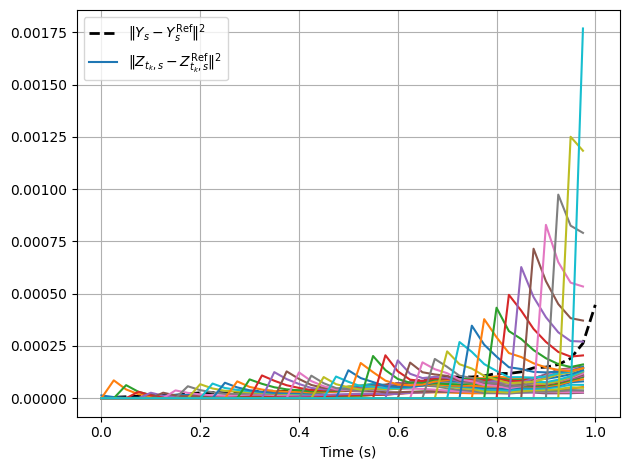

In [ ]:
print('||Y-Y_R\||^2: (Exact ref.) ', T * np.mean((Y[:,:,0]-Y_ref)**2))
print('||Z-Z_R\||^2: (Exact ref.) ', 2 * T * np.mean((Z-Z_ref)**2)) # 50% of the entries are zero by default.
print('||Y-Y_R\||^2: (Relative) ', T * np.mean(((Y[:,:,0]-Y_ref)/(np.abs(Y_ref) + 0.01)))**2)
print('||Z-Z_R\||^2: (Relative) ', 2 * T * np.mean(((Z-Z_ref)/(np.abs(Z_ref) + 0.01))**2)) # 50% of the entries are zero by default.
print('||Y-Y_R\||^2: (EM ref.) ', T * np.mean((Y_EM[:,:,0]-Y_ref)**2))
print('||Z-Z_R\||^2: (EM ref.)', 2 * T * np.mean((Z_EM-Z_ref)**2)) # 50% of the entries are zero by default.
print('|Y_0-Y_0^R|^2: ', np.mean(Y[:,0,0]-Y_ref[:,0]))
print('|Y_0-Y_0^R|^2 (relative): ', np.mean(Y[:,0,0]-Y_ref[:,0])/Y[0,0,0])

plt.plot(t, np.mean(np.abs(Y_ref-Y[:,:,0])**2,0), '--k', linewidth = 2)
#plt.plot(t,np.mean(np.abs(t*np.sin(X[:,:,0])-Y[:,:,0]),0), '--')
for k in range(0,N,np.maximum(int(N/40),1)):
  plt.plot(t[:-1],np.mean(np.abs(Z_ref[:,k,:,0]-Z[:,k,:,0])**2,0))
plt.legend([r'$\|Y_s-Y_s^\text{Ref}\|^2$', r'$\|Z_{t_k,s}-Z_{t_k,s}^\text{Ref}\|^2$'])
plt.xlabel('Time (s)')
plt.grid(True)
plt.tight_layout()
plt.show()

diff = (Y[:,:,0]-Y_ref)**2
idx = np.argmax(diff)
i, j = np.unravel_index(idx, diff.shape)



In [ ]:
d=1 10 min
||Y-Y_R\||^2: (Relative)  5.6877451703923755e-08
||Z-Z_R\||^2: (Relative)  0.0008587301696938897

d=5 12 min 47s per epoch
||Y-Y_R\||^2: (Relative)  8.870437214112656e-05
||Z-Z_R\||^2: (Relative)  0.013128116502025

d=20 19 min 91s per epoch
||Y-Y_R\||^2: (Relative)  0.0001173084876076209
||Z-Z_R\||^2: (Relative)  0.03400321175435788

d=40 19 min 90s per epoch
||Y-Y_R\||^2: (Relative)  0.003368601903377733
||Z-Z_R\||^2: (Relative)  0.5697294815230886
d=40 34 min 180s per epoch
||Y-Y_R\||^2: (Relative)  0.009337544614756265
||Z-Z_R\||^2: (Relative)  0.1030756056134353

New example
d=500 48s per epoch
||Y-Y_R\||^2: (Exact ref.)  0.008023294585632492
||Z-Z_R\||^2: (Exact ref.)  2.9136763277872074e-06
||Y-Y_R\||^2: (Relative)  0.6693581471876562
||Z-Z_R\||^2: (Relative)  0.02689312643458119

d=100 48s per epoch
||Y-Y_R\||^2: (Exact ref.)  0.0013097428648888216
||Z-Z_R\||^2: (Exact ref.)  4.4647716743815345e-06
||Y-Y_R\||^2: (Relative)  0.017451628597443248
||Z-Z_R\||^2: (Relative)  0.021592432760704904

d=20 48s per epoch
||Y-Y_R\||^2: (Exact ref.)  0.00017847263773019
||Z-Z_R\||^2: (Exact ref.)  7.941512998819967e-06
||Y-Y_R\||^2: (Relative)  8.325150986694183e-05
||Z-Z_R\||^2: (Relative)  0.02117711617717048

d=5 48s per epoch
||Y-Y_R\||^2: (Exact ref.)  9.614611811792114e-05
||Z-Z_R\||^2: (Exact ref.)  2.9120346988141052e-05
||Y-Y_R\||^2: (Relative)  0.00019447494234916494
||Z-Z_R\||^2: (Relative)  0.015341064873625654

d=1 43s per epoch
||Y-Y_R\||^2: (Exact ref.)  7.694101376425224e-05
||Z-Z_R\||^2: (Exact ref.)  8.166736680789188e-05
||Y-Y_R\||^2: (Relative)  0.00019507363634015348
||Z-Z_R\||^2: (Relative)  0.023981052658623953





In [ ]:
err_z = np.array([0.0008587301696938897, 0.013128116502025, 0.3421983106190385, 0.5697294815230886])
d = np.array([1,5,20,40])
err_z/d

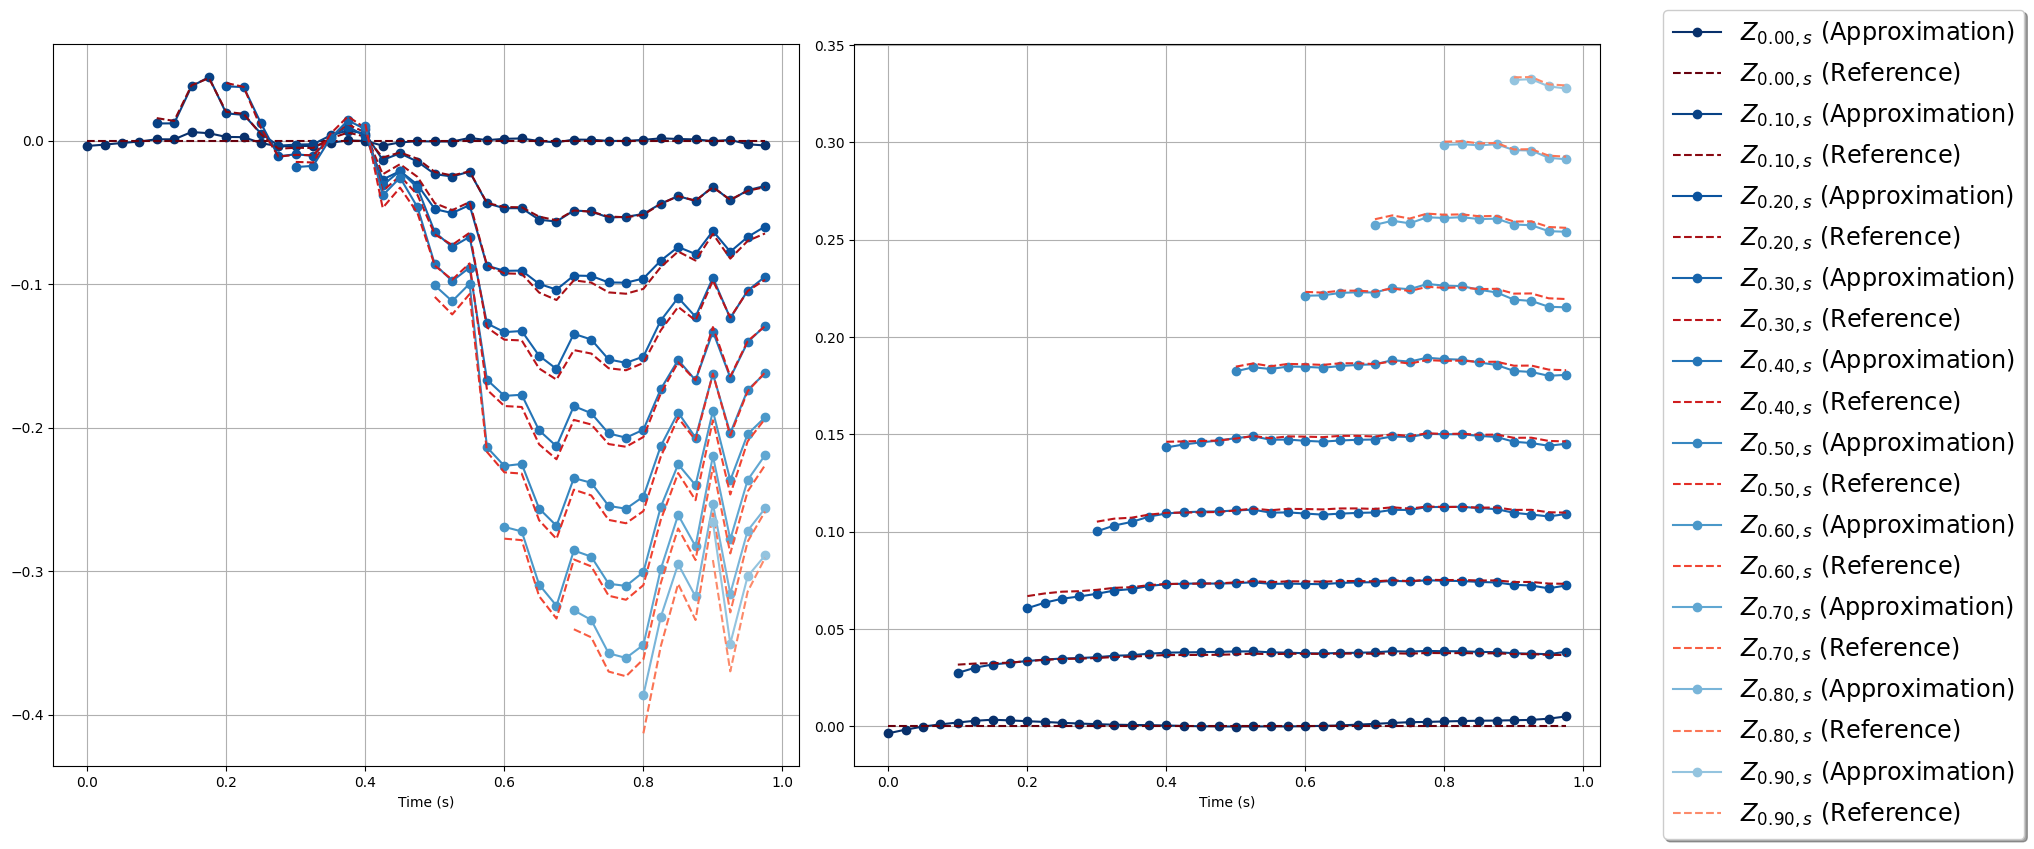

In [ ]:
m = np.random.randint(0, M-1)  # choose a random index (ensure m+1 is valid)
m = 0
# Define the set of k values and related parameters.
k_values = list(range(0, min(N, Y.shape[1]), max(int(N/10), 1)))
num_curves = len(k_values)
min_frac = 0.4
max_frac = 1.0

# Create a figure with two subplots arranged horizontally.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# ---- Left Subplot: Plot without expectations (legend will come from here) ----
comp = 0
for i, k in enumerate(k_values):
    t_range = t[k:-1]          # time points corresponding to Z evaluation.
    t_value = k * h            # numerical value of t = k*h.
    frac = min_frac + (max_frac - min_frac) * (1 - i/(num_curves - 1)) if num_curves > 1 else 1.0

    blue_color = plt.cm.Blues(frac)
    red_color  = plt.cm.Reds(frac)

    # Labels without expectation operator.
    label_approx = rf'$Z_{{{t_value:.2f},s}}$ (Approximation)'
    label_ref = rf'$Z_{{{t_value:.2f},s}}$ (Reference)'

    ax1.plot(t_range, Z[m, k, k:, comp], marker='o', linestyle='-', color=blue_color, label=label_approx)
    ax1.plot(t_range, Z_ref[m, k, k:, comp], '--', color=red_color, label=label_ref)

ax1.set_xlabel('Time (s)')
ax1.grid(True)

# ---- Right Subplot: Plot with expectations (legend not displayed here) ----
comp = 0
for i, k in enumerate(k_values):
    t_range = t[k:-1]          # time points corresponding to Z evaluation.
    t_value = k * h            # numerical value of t = k*h.
    frac = min_frac + (max_frac - min_frac) * (1 - i/(num_curves - 1)) if num_curves > 1 else 1.0

    blue_color = plt.cm.Blues(frac)
    red_color  = plt.cm.Reds(frac)

    # Labels with expectation operator (not used for the legend)
    # label_approx = rf'$\mathbf{{E}}[Z_{{{t_value:.2f},s}}]$ (Approximation)'
    # label_ref = rf'$\mathbf{{E}}[Z_{{{t_value:.2f},s}}]$ (Reference)'

    ax2.plot(t_range, np.mean(Z[:, k, k:, comp], axis=0), marker='o', linestyle='-', color=blue_color)
    ax2.plot(t_range, np.mean(Z_ref[:, k, k:, comp], axis=0), '--', color=red_color)

ax2.set_xlabel('Time (s)')
ax2.grid(True)

# ---- Global Legend placed on the right side of the figure ----
# Use the handles and labels from ax1 (the non-expectation labels).
handles, labels = ax1.get_legend_handles_labels()
# Place the global legend to the right of the entire figure.
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.92, 0.5),
           fontsize='xx-large', frameon=True, fancybox=True, shadow=True)
# Adjust layout to leave space for the legend.
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

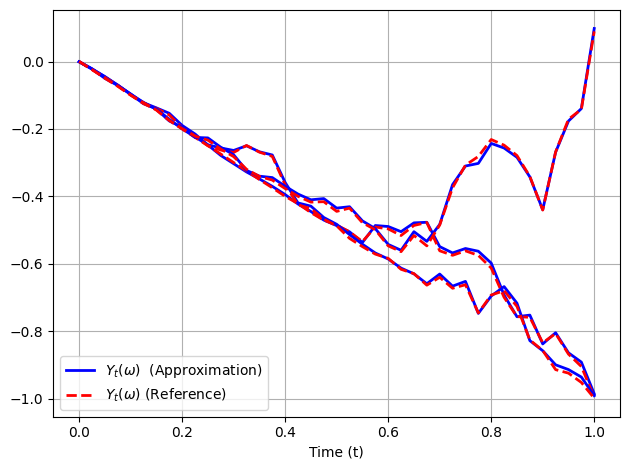

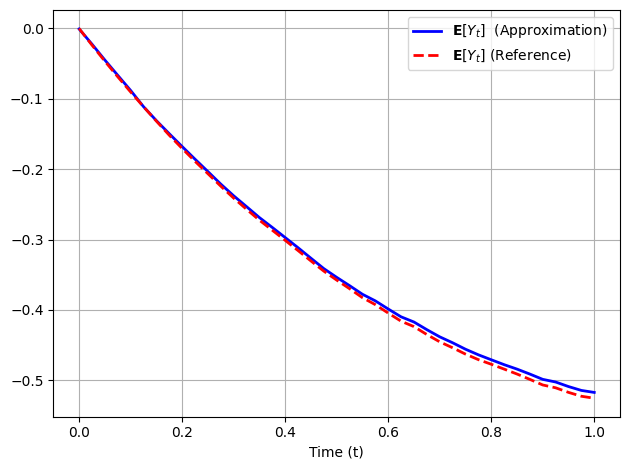

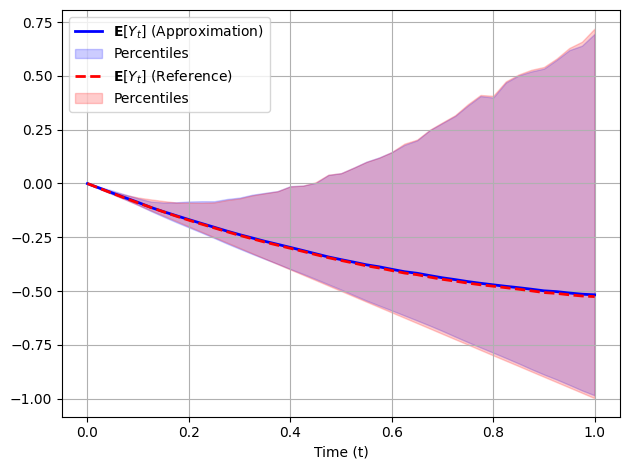

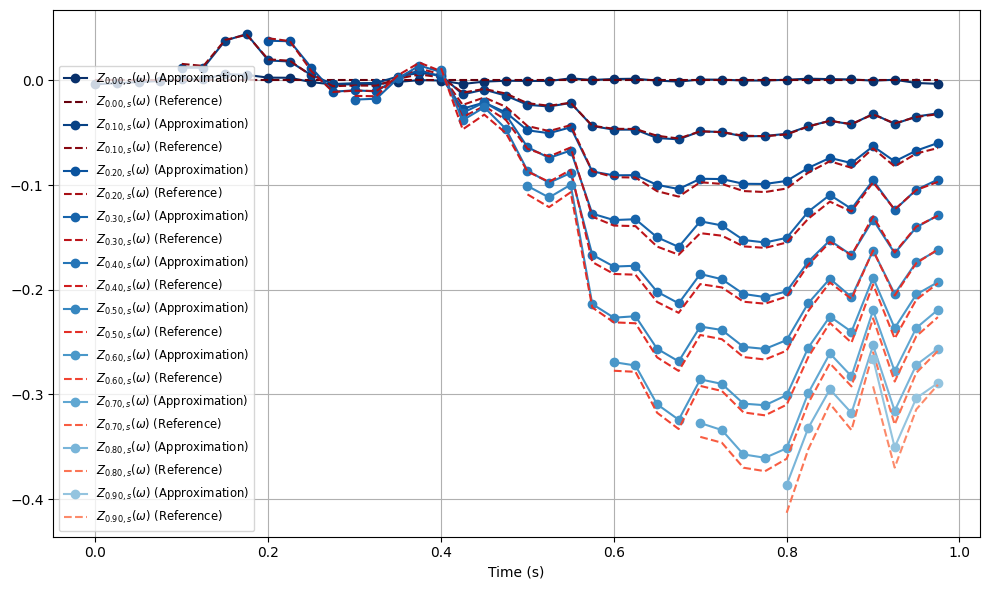

<Figure size 1000x600 with 0 Axes>

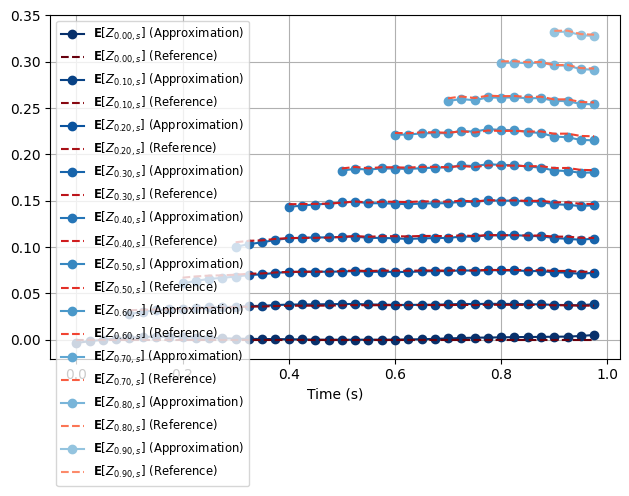

In [ ]:
m = np.random.randint(0, M-1)  # choose a random index (ensure m+1 is valid)
m = 0
# --- Figure 1: Compare Approximated Y and Analytical Y ---
plt.figure()
plt.plot(t, Y[m, :, 0], color = 'blue', label=r'$Y_t(\omega)$  (Approximation)', linewidth=2)
plt.plot(t, Y_ref[m, :], '--', color = 'red', label=r'$Y_t(\omega)$ (Reference)', linewidth=2)
plt.plot(t, Y[m+1, :, 0], color = 'blue', linewidth=2)
plt.plot(t, Y_ref[m+1, :], '--', color = 'red', linewidth=2)
plt.plot(t, Y[m+2, :, 0], color = 'blue', linewidth=2)
plt.plot(t, Y_ref[m+2, :], '--', color = 'red', linewidth=2)
plt.xlabel('Time (t)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(t, np.mean(Y[:, :, 0],0), color = 'blue', label=r'$\mathbf{{E}}[Y_t]$  (Approximation)', linewidth=2)
plt.plot(t, np.mean(Y_ref, 0), '--', color = 'red', label=r'$\mathbf{{E}}[Y_t]$ (Reference)', linewidth=2)
plt.xlabel('Time (t)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



plt.figure()

Y_mean = np.mean(Y[:, :, 0], axis=0)
ref_vals = t * np.sin(np.sum(X, axis=2))  # shape (M, N)
ref_mean = np.mean(Y_ref, axis=0)
Y_lower = np.percentile(Y[:, :, 0], 5, axis=0)
Y_upper = np.percentile(Y[:, :, 0], 95, axis=0)
ref_lower = np.percentile(Y_ref, 5, axis=0)
ref_upper = np.percentile(Y_ref, 95, axis=0)

plt.plot(t, Y_mean, color='blue', label=r'$\mathbf{{E}}[Y_t]$ (Approximation)', linewidth=2)
plt.fill_between(t, Y_lower, Y_upper,  label='Percentiles', color='blue', alpha=0.2)

plt.plot(t, ref_mean, '--', color='red', label=r'$\mathbf{{E}}[Y_t]$ (Reference)', linewidth=2)
plt.fill_between(t, ref_lower, ref_upper, label='Percentiles' , color='red', alpha=0.2)

plt.xlabel('Time (t)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



plt.figure(figsize=(10,6))
# Define the set of k values and total number of curves.
k_values = list(range(0, min(N, Y.shape[1]), int(N/10)))
num_curves = len(k_values)
# Set minimum and maximum fraction values for the colormap.
min_frac = 0.4
max_frac = 1.0

comp = 0

for i, k in enumerate(k_values):
    t_range = t[k:-1]  # time points corresponding to Z evaluation.
    t_value = k * h    # numerical value of t = k*h.
    # Compute fraction such that i=0 gives max_frac and i=num_curves-1 gives min_frac.
    if num_curves > 1:
        frac = min_frac + (max_frac - min_frac) * (1 - i/(num_curves - 1))
    else:
        frac = 1.0

    blue_color = plt.cm.Blues(frac)
    red_color  = plt.cm.Reds(frac)

    # Create labels with t_value in the subscript.
    label_approx = rf'$Z_{{{t_value:.2f},s}}(\omega)$ (Approximation)'
    label_ref = rf'$Z_{{{t_value:.2f},s}}(\omega)$ (Reference)'

    plt.plot(t_range, Z[m,k, k:, comp], marker='o', linestyle='-', color=blue_color, label=label_approx)
    plt.plot(t_range, Z_ref[m, k, k:, comp], '--', color=red_color, label=label_ref)
plt.xlabel('Time (s)')
plt.legend(fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,6))
plt.figure()
# Define the set of k values and total number of curves.
k_values = list(range(0, min(N, Y.shape[1]), int(N/10)))
num_curves = len(k_values)
# Set minimum and maximum fraction values for the colormap.
min_frac = 0.4
max_frac = 1.0

comp = 0

for i, k in enumerate(k_values):
    t_range = t[k:-1]  # time points corresponding to Z evaluation.
    t_value = k * h    # numerical value of t = k*h.
    # Compute fraction such that i=0 gives max_frac and i=num_curves-1 gives min_frac.
    if num_curves > 1:
        frac = min_frac + (max_frac - min_frac) * (1 - i/(num_curves - 1))
    else:
        frac = 1.0

    blue_color = plt.cm.Blues(frac)
    red_color  = plt.cm.Reds(frac)

    # Create labels with t_value in the subscript.
    label_approx = rf'$\mathbf{{E}}[Z_{{{t_value:.2f},s}}]$ (Approximation)'
    label_ref = rf'$\mathbf{{E}}[Z_{{{t_value:.2f},s}}]$ (Reference)'

    plt.plot(t_range, np.mean(Z[:,k, k:, comp], 0), marker='o', linestyle='-', color=blue_color, label=label_approx)
    plt.plot(t_range, np.mean(Z_ref[:, k, k:, comp], 0), '--', color=red_color, label=label_ref)
plt.legend(fontsize='small')
#plt.legend(fontsize='small', handlelength=1, handletextpad=0.2, borderpad=0.2, labelspacing=0.1, ncol=4)
#plt.legend(fontsize='small', ncol=1, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel('Time (s)')
#plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()










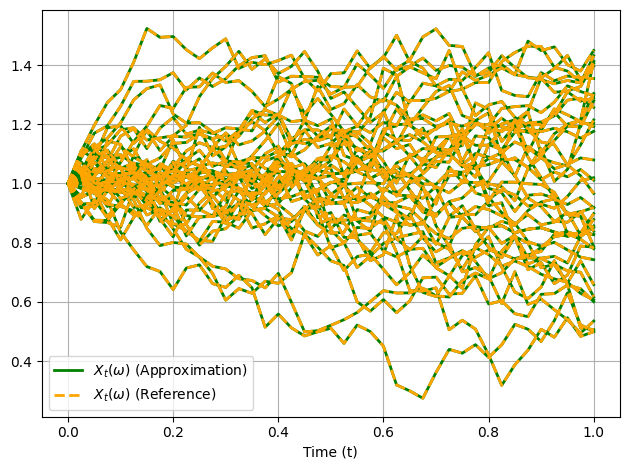

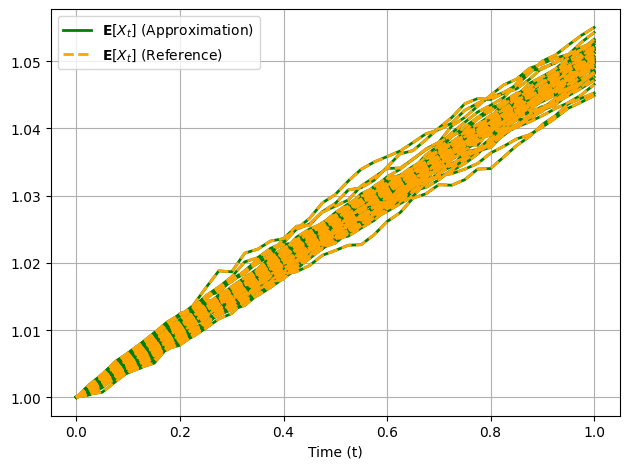

In [ ]:
# Choose a random index ensuring that m+1 and m+2 are valid indices
m = np.random.randint(0, M-2)

if d==1:
  # --- Figure: Compare Approximated X and Reference X ---
  plt.figure()
  plt.plot(t, X_EM[m, :, 0], color='green', label=r'$X_t(\omega)$ (Approximation)', linewidth=2)
  plt.plot(t, X[m, :], '--', color='orange', label=r'$X_t(\omega)$ (Reference)', linewidth=2)
  plt.plot(t, X_EM[m+1, :, 0], color='green', linewidth=2)
  plt.plot(t, X[m+1, :], '--', color='orange', linewidth=2)
  plt.plot(t, X_EM[m+2, :, 0], color='green', linewidth=2)
  plt.plot(t, X[m+2, :], '--', color='orange', linewidth=2)
  plt.xlabel('Time (t)')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

  # --- Figure: Compare Mean of Approximated X and Reference X ---
  plt.figure()
  plt.plot(t, np.mean(X_EM[:, :, 0], axis=0), color='green', label=r'$\mathbf{E}[X_t]$ (Approximation)', linewidth=2)
  plt.plot(t, np.mean(X, axis=0), '--', color='orange', label=r'$\mathbf{E}[X_t]$ (Reference)', linewidth=2)
  plt.xlabel('Time (t)')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()


  plt.figure()

  # Squeeze to remove any singleton dimensions so that arrays become 2D (M, N)
  X_EM_slice = np.squeeze(X_EM[:, :, 0])  # shape becomes (M, N)
  X_slice    = np.squeeze(X[:, :, 0])     # shape becomes (M, N)

  # Compute statistics along the sample dimension (axis=0) to get 1D arrays of length N
  X_mean    = np.mean(X_EM_slice, axis=0)
  ref_mean  = np.mean(X_slice, axis=0)
  X_lower   = np.percentile(X_EM_slice, 5, axis=0)
  X_upper   = np.percentile(X_EM_slice, 95, axis=0)
  ref_lower = np.percentile(X_slice, 5, axis=0)
  ref_upper = np.percentile(X_slice, 95, axis=0)

  # Plot the approximation (X_EM) using green
  plt.plot(t, X_mean, color='green', label=r'$\mathbf{E}[X_t]$ (Approximation)', linewidth=2)
  plt.fill_between(t, X_lower, X_upper, color='green', alpha=0.2)

  # Plot the reference (X) using orange, with a dashed line
  plt.plot(t, ref_mean, '--', color='orange', label=r'$\mathbf{E}[X_t]$ (Reference)', linewidth=2)
  plt.fill_between(t, ref_lower, ref_upper, color='orange', alpha=0.2)

  plt.xlabel('Time (t)')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

else:

# --- Figure: Compare Approximated X and Reference X ---
  plt.figure()
  plt.plot(t, X_EM[m, :, 0], color='green', label=r'$X_t(\omega)$ (Approximation)', linewidth=2)
  plt.plot(t, X[m, :,0], '--', color='orange', label=r'$X_t(\omega)$ (Reference)', linewidth=2)
  plt.plot(t, X_EM[m, :, :], color='green', linewidth=2)
  plt.plot(t, X[m, :,:], '--', color='orange', linewidth=2)
  plt.xlabel('Time (t)')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

  # --- Figure: Compare Mean of Approximated X and Reference X ---
  plt.figure()
  plt.plot(t, np.mean(X_EM[:,:,0], axis=0), color='green', label=r'$\mathbf{E}[X_t]$ (Approximation)', linewidth=2)
  plt.plot(t, np.mean(X[:,:,0], axis=0), '--', color='orange', label=r'$\mathbf{E}[X_t]$ (Reference)', linewidth=2)
  plt.plot(t, np.mean(X_EM, axis=0), color='green', linewidth=2)
  plt.plot(t, np.mean(X, axis=0), '--', color='orange',  linewidth=2)
  plt.xlabel('Time (t)')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()






<Figure size 640x480 with 0 Axes>

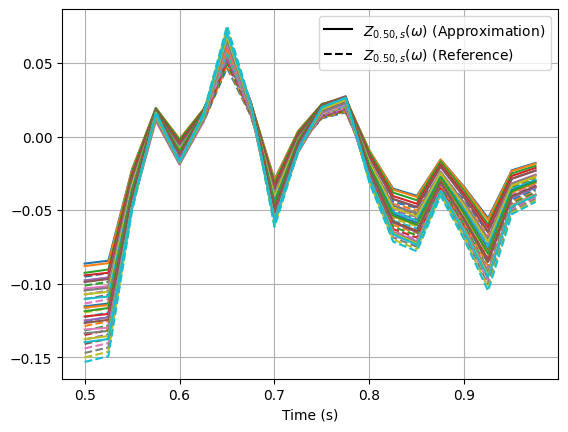

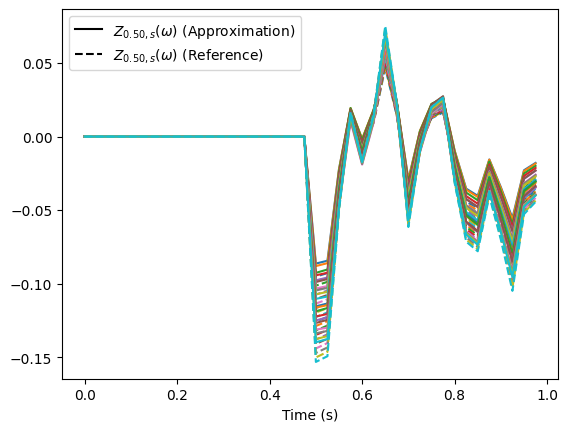

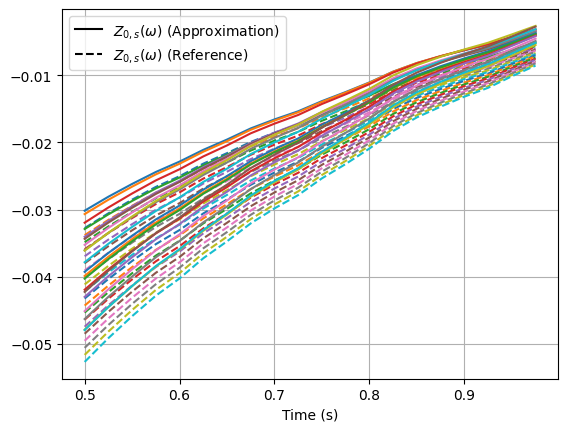

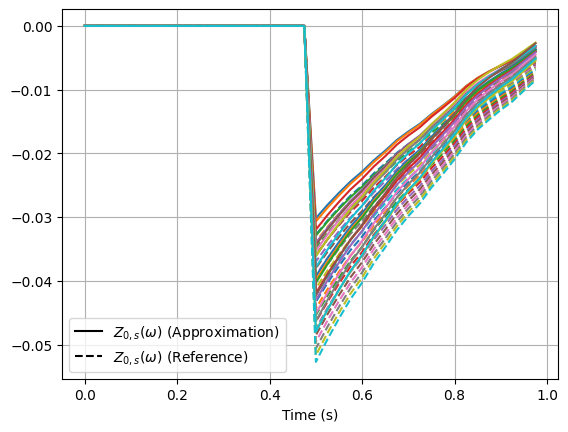

In [ ]:
plt.figure()
k = 20
legend_value = k * h
num_components = 20
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure()
plt.grid()

# Loop over components and plot using the same color for both solutions
for i in range(0,num_components):
    color = colors[i % len(colors)]
    plt.plot(t[k:-1], Z[0, k, k:, i], color=color, linestyle='-')
    plt.plot(t[k:-1], Z_ref[0, k, k:, i], color=color, linestyle='--')

# Create custom legend handles to indicate which line style corresponds to which solution type
approx_handle = plt.Line2D([], [], color='black', linestyle='-',
                           label=f'$Z_{{{legend_value:.2f},s}}(\\omega)$ (Approximation)')
ref_handle = plt.Line2D([], [], color='black', linestyle='--',
                        label=f'$Z_{{{legend_value:.2f},s}}(\\omega)$ (Reference)')
plt.legend(handles=[approx_handle, ref_handle])

plt.xlabel("Time (s)")
plt.show()

# Loop over components and plot using the same color for both solutions
for i in range(0,num_components):
    color = colors[i % len(colors)]
    plt.plot(t[:-1], Z[0, k, :, i], color=color, linestyle='-')
    plt.plot(t[:-1], Z_ref[0, k, :, i], color=color, linestyle='--')

# Create custom legend handles to indicate which line style corresponds to which solution type
approx_handle = plt.Line2D([], [], color='black', linestyle='-',
                           label=f'$Z_{{{legend_value:.2f},s}}(\\omega)$ (Approximation)')
ref_handle = plt.Line2D([], [], color='black', linestyle='--',
                        label=f'$Z_{{{legend_value:.2f},s}}(\\omega)$ (Reference)')
plt.legend(handles=[approx_handle, ref_handle])

plt.xlabel("Time (s)")
plt.show()


plt.figure()
plt.grid()

# Loop over components and plot using the same color for both solutions
for i in range(num_components):
    color = colors[i % len(colors)]
    plt.plot(t[k:-1], np.mean(Z[:, k, k:, i],0), color=color, linestyle='-')
    plt.plot(t[k:-1], np.mean(Z_ref[:, k, k:, i],0), color=color, linestyle='--')

# Create custom legend handles to indicate which line style corresponds to which solution type
approx_handle = plt.Line2D([], [], color='black', linestyle='-', label=r'$Z_{0,s}(\omega)$ (Approximation)')
ref_handle = plt.Line2D([], [], color='black', linestyle='--', label=r'$Z_{0,s}(\omega)$ (Reference)')
plt.legend(handles=[approx_handle, ref_handle])

plt.xlabel("Time (s)")
plt.show()

plt.figure()
plt.grid()

# Loop over components and plot using the same color for both solutions
for i in range(num_components):
    color = colors[i % len(colors)]
    plt.plot(t[:-1], np.mean(Z[:, k, :, i],0), color=color, linestyle='-')
    plt.plot(t[:-1], np.mean(Z_ref[:, k, :, i],0), color=color, linestyle='--')

# Create custom legend handles to indicate which line style corresponds to which solution type
approx_handle = plt.Line2D([], [], color='black', linestyle='-', label=r'$Z_{0,s}(\omega)$ (Approximation)')
ref_handle = plt.Line2D([], [], color='black', linestyle='--', label=r'$Z_{0,s}(\omega)$ (Reference)')
plt.legend(handles=[approx_handle, ref_handle])

plt.xlabel("Time (s)")
plt.show()


In [ ]:
# Compute the value to be displayed in the legend
k=5
legend_value = k * h  # For example, if k=10 and h=0.025, legend_value = 0.25

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# First figure: Plot without averaging
plt.figure(figsize=(10, 6))
plt.grid()

# Loop over components and plot using the same color for both solutions
for i in range(num_components):
    color = colors[i % len(colors)]
    plt.plot(t[k:-1], Z[0, k, k:, i], color=color, linestyle='-')
    plt.plot(t[k:-1], Z_ref[0, k, k:, i], color=color, linestyle='--')

# Create custom legend handles using f-strings to include the numerical value
approx_handle = plt.Line2D([], [], color='black', linestyle='-',
                           label=f'$Z_{{{legend_value:.2f},s}}(\\omega)$ (Approximation)')
ref_handle = plt.Line2D([], [], color='black', linestyle='--',
                        label=f'$Z_{{{legend_value:.2f},s}}(\\omega)$ (Reference)')
plt.legend(handles=[approx_handle, ref_handle])

plt.xlabel("Time (s)")
plt.title("Component Comparison (without averaging)")
plt.show()

# Second figure: Plot with averaging over the first axis
plt.figure(figsize=(10, 6))
plt.grid()

# Loop over components and plot using the same color for both solutions
for i in range(num_components):
    color = colors[i % len(colors)]
    plt.plot(t[k:-1], np.mean(Z[:, k, k:, i], axis=0), color=color, linestyle='-')
    plt.plot(t[k:-1], np.mean(Z_ref[:, k, k:, i], axis=0), color=color, linestyle='--')

approx_handle = plt.Line2D([], [], color='black', linestyle='-',
                           label=f'$Z_{{{legend_value:.2f},s}}(\\omega)$ (Approximation)')
ref_handle = plt.Line2D([], [], color='black', linestyle='--',
                        label=f'$Z_{{{legend_value:.2f},s}}(\\omega)$ (Reference)')
plt.legend(handles=[approx_handle, ref_handle])

plt.xlabel("Time (s)")
plt.title("Component Comparison (with averaging)")
plt.show()